# Theory vs experiment plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

import sys
sys.path.insert(0, "../scripts")
from learning_theory import get_finite_f_bound, get_mcallester_bound, requirement_from_finite_f_bound

In [2]:
df = pd.read_csv("../reports/0830_gaussian_noised_past_present.csv")
print(df.shape)
bg_df = pd.read_csv("../reports/0922_bigram_shift.csv")
print(bg_df.shape)
hid20_df = pd.read_csv("../reports/0927_past_present_bigram_shift_hidsize20.csv")
print(hid20_df.shape)
sentlen_df = pd.read_csv("../reports/1012_sentence_length.csv")
print(sentlen_df.shape)
coordinv_df = pd.read_csv("../reports/1012_coordination_inversion.csv")
print(coordinv_df.shape)
df_all = pd.concat([df, bg_df, hid20_df, sentlen_df, coordinv_df], axis=0)
df_all.shape

(1245, 27)
(175, 27)
(50, 27)
(160, 26)
(200, 26)


(1830, 27)

In [3]:
NUM_CLASSES = 2
df_all["N_train_data"] = df_all["train_size_per_class"] * NUM_CLASSES
df_all.columns

Index(['Name', 'Created', 'Runtime', 'State', 'Updated', 'Hostname',
       'max_epochs', 'task', 'probe_metric', 'hid_sizes', 'seed',
       'train_size_per_class', 'val_size_per_class', 'use_cuda', 'model',
       'slurm_id', 'min_epochs', 'representation_gaussian_noise',
       'best_hyperparameters.batch_size', 'best_hyperparameters.lr',
       'test_loss', 'best_val_acc', 'best_val_loss', 'test_acc',
       'best_test_predictions', 'test_labels', 'test_predictions',
       'N_train_data'],
      dtype='object')

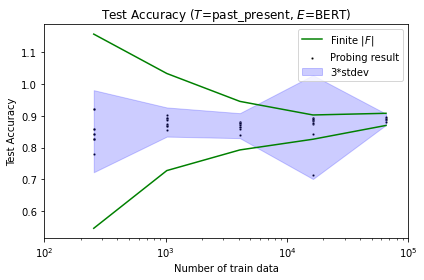

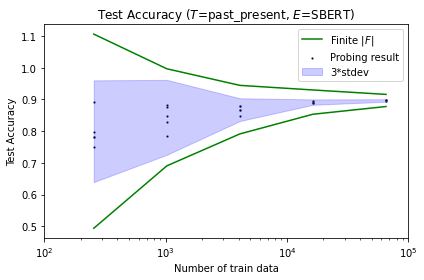

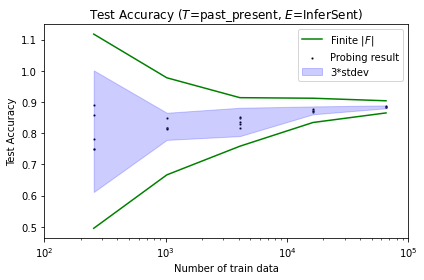

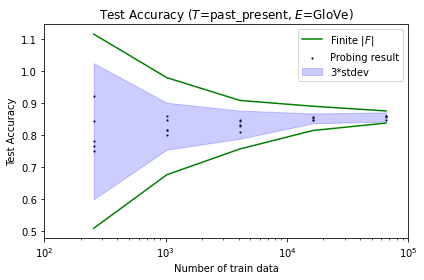

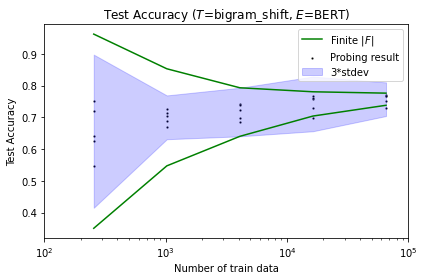

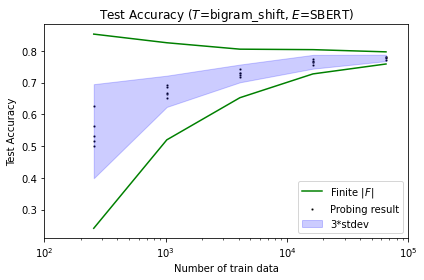

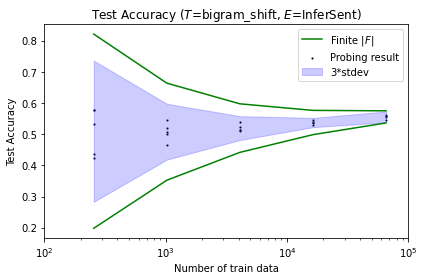

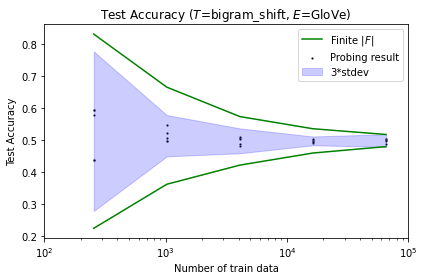

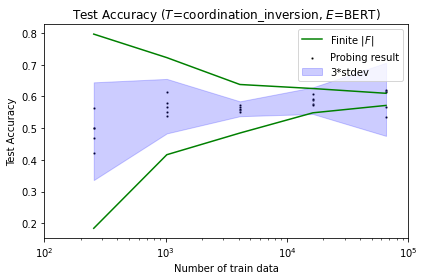

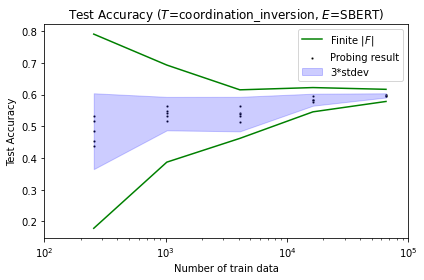

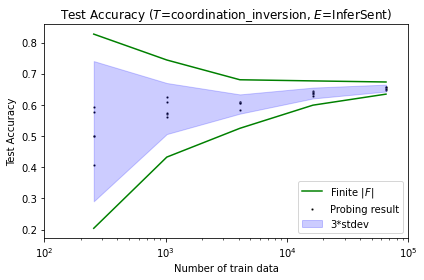

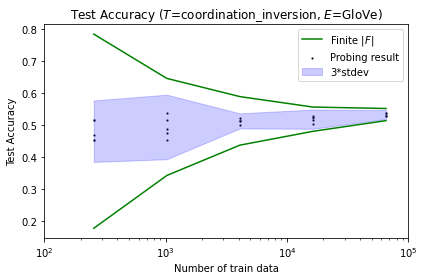

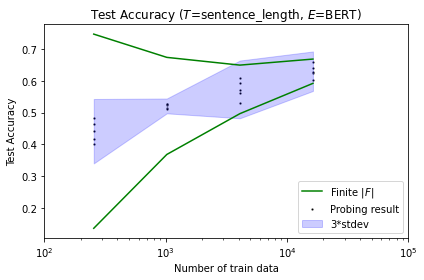

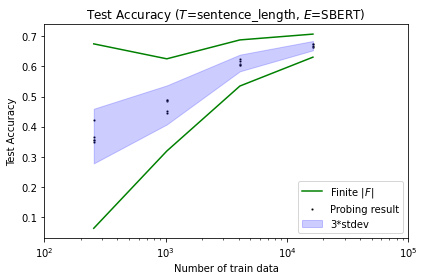

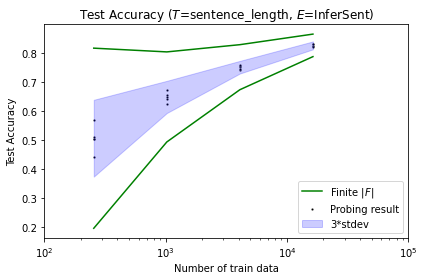

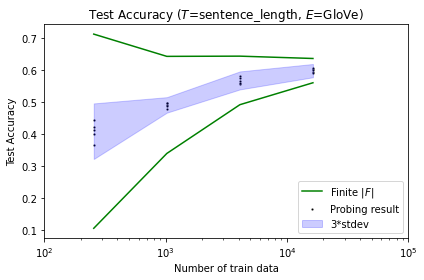

In [12]:
def plot_against_n(df, task="past_present", model="bert", metric="best_val_acc", fix_ylim=False, save=False):
    dimen_by_model = {
        "bert": 768, "bert_corr200": 768, "bert_corr800": 768,
        "bert_corr3200": 768, "sbert": 768,
        "infersent": 4096, "glove": 300
    }
    bound_by_metric = {
        "test_acc": 1, "best_val_acc": 1, "val_acc": 1,
        "best_val_loss": 5, "test_loss": 5
    }
    model_nl = {"bert": "BERT", "sbert": "SBERT", "glove": "GloVe", "infersent": "InferSent"}[model]
    metric_nl = {"test_acc": "Test Accuracy", "val_acc": "Validation Accuracy"}[metric]
    
    df_plot = df[(df.probe_metric=="others") & (df.task==task) & \
                 (df.model==model) & (df.representation_gaussian_noise==0) & \
                 (df.hid_sizes=="[]")]

    df_plot = df_plot[["N_train_data", "best_val_acc", "best_val_loss", "test_acc"]]
    
    plt.figure()
    splot = sns.scatterplot(data=df_plot, y=metric, x="N_train_data", label="Probing result", color="black", s=5)
    splot.set_xscale("log")
    
    x_ticks = sorted(df_plot["N_train_data"].drop_duplicates())
    
    means = []
    stdevs = []
    finite_f_bounds = []
    pac_bayes_bounds = []
    for x in x_ticks:
        data_here = df_plot[df_plot["N_train_data"]==x][metric]
        mean = data_here.mean()
        stdev = data_here.std()
        means.append(mean)
        stdevs.append(stdev)
        finite_f_bounds.append(get_finite_f_bound(x, B=bound_by_metric[metric], D=dimen_by_model[model]) / 2)
        pac_bayes_bounds.append(get_mcallester_bound(x, B=bound_by_metric[metric]) / 2)
    means = np.array(means)
    uncertainty = np.array(stdevs) * 3
    plt.fill_between(x_ticks, means-uncertainty, means+uncertainty, color="blue", alpha=0.2, label="3*stdev")
    
    plt.plot(x_ticks, means + np.array(finite_f_bounds), "g-", label="Finite |$F$|")
    plt.plot(x_ticks, means - np.array(finite_f_bounds), "g-")
    #plt.plot(x_ticks, means + np.array(pac_bayes_bounds), color="b", linestyle="dashdot", label="McAllester")
    #plt.plot(x_ticks, means - np.array(pac_bayes_bounds), color="b", linestyle="dashdot")

    splot.legend()
    xtick_nums = [1e2, 1e3, 1e4, 1e5]
    xtick_texts = ["$10^2$", "$10^3$", "$10^4$", "$10^5$"]
    splot.set_xticks(xtick_nums)
    splot.set_xticklabels(xtick_texts)
    splot.set_xlabel("Number of train data")
    splot.set_ylabel(metric_nl)
    splot.set_title(f"{metric_nl} ($T$={task}, $E$={model_nl})")
    
    if fix_ylim:
        plt.ylim([0,1])
        plt.savefig(f"0915_theoretical_bounds_plot/fix_ylim_0_1/{task}_{model}_{metric}.svg")
    if save:
        plt.tight_layout()
        plt.savefig(f"0915_theoretical_bounds_plot/all_range/{task}_{model}_{metric}.svg")
        
for task in ["past_present", "bigram_shift", "coordination_inversion", "sentence_length"]:
    for model in ["bert", "sbert", "infersent", "glove"]:
        plot_against_n(df_all, task, model, "test_acc", fix_ylim=False, save=True)